In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
im1 = np.load('maze1.npy')

In [5]:
im1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

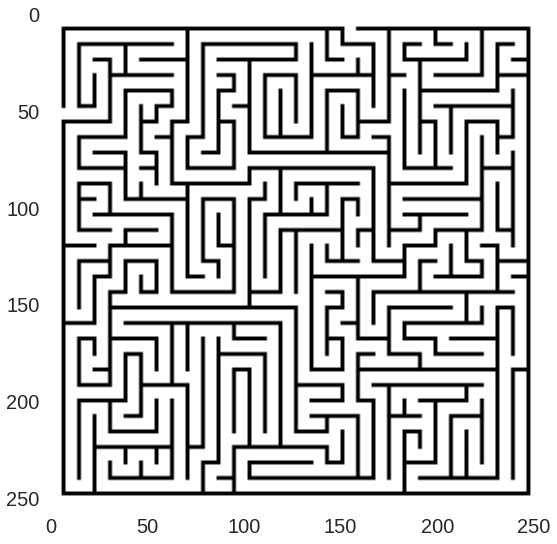

In [7]:
plt.imshow(im1)
plt.grid(False)

In [11]:
from __future__ import division
import sys
import pyopencl as cl
import numpy as np

def round_up(global_size, group_size):
    r = global_size % group_size
    if r == 0:
        return global_size
    return global_size + group_size - r

The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.18
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
---------------------------
This context is associated with  1 devices
The queue is using the device: GeForce GTX TITAN Black
(256, 256)
1530
64516


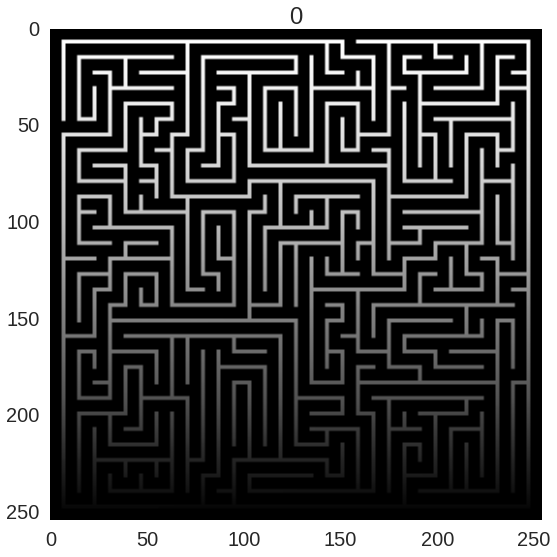

In [12]:
# List our platforms
platforms = cl.get_platforms()
print 'The platforms detected are:'
print '---------------------------'
for platform in platforms:
    print platform.name, platform.vendor, 'version:', platform.version

# List devices in each platform
for platform in platforms:
    print 'The devices detected on platform', platform.name, 'are:'
    print '---------------------------'
    for device in platform.get_devices():
        print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
        print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
        print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
        print 'Maximum work group size', device.max_work_group_size
        print '---------------------------'

# Create a context with all the devices
devices = platforms[0].get_devices()
context = cl.Context(devices)
print 'This context is associated with ', len(context.devices), 'devices'

# Create a queue for transferring data and launching computations.
# Turn on profiling to allow us to check event times.
queue = cl.CommandQueue(context, context.devices[0],
                        properties=cl.command_queue_properties.PROFILING_ENABLE)
print 'The queue is using the device:', queue.device.name

program = cl.Program(context, open('label_regions.cl').read()).build(options='')

host_image = np.load('maze1.npy')
host_labels = np.empty_like(host_image)
host_done_flag = np.zeros(1).astype(np.int32)

gpu_image = cl.Buffer(context, cl.mem_flags.READ_ONLY, host_image.size * 4)
gpu_labels = cl.Buffer(context, cl.mem_flags.READ_WRITE, host_image.size * 4)
gpu_done_flag = cl.Buffer(context, cl.mem_flags.READ_WRITE, 4)

# Send to the device, non-blocking
cl.enqueue_copy(queue, gpu_image, host_image, is_blocking=False)

local_size = (8, 8)  # 64 pixels per work group
global_size = tuple([round_up(g, l) for g, l in zip(host_image.shape[::-1], local_size)])
print global_size
width = np.int32(host_image.shape[1])
height = np.int32(host_image.shape[0])
halo = np.int32(1)

# Create a local memory per working group that is
# the size of an int (4 bytes) * (N+2) * (N+2), where N is the local_size
buf_size = (np.int32(local_size[0] + 2 * halo), np.int32(local_size[1] + 2 * halo))
gpu_local_memory = cl.LocalMemory(4 * buf_size[0] * buf_size[1])

# initialize labels
program.initialize_labels(queue, global_size, local_size,
                          gpu_image, gpu_labels,
                          width, height)

# while not done, propagate labels
itercount = 0

# Show the initial labels
cl.enqueue_copy(queue, host_labels, gpu_labels, is_blocking=True)
print np.min(host_labels)
print np.max(host_labels)
pylab.imshow(host_labels)
pylab.title(itercount)
plt.grid(False)

I'm confused. 

In [21]:
host_labels[20, 6]

5086

In [25]:
rows = host_labels.shape[0]
cols = host_labels.shape[1]

In [28]:
254*254

64516

In [29]:
host_labels

array([[64516, 64516, 64516, ..., 64516, 64516, 64516],
       [64516, 64516, 64516, ..., 64516, 64516, 64516],
       [64516, 64516, 64516, ..., 64516, 64516, 64516],
       ..., 
       [64516, 64516, 64516, ..., 64516, 64516, 64516],
       [64516, 64516, 64516, ..., 64516, 64516, 64516],
       [64516, 64516, 64516, ..., 64516, 64516, 64516]], dtype=int32)

In [27]:
host_labels.shape

(254, 254)

In [23]:
20*cols + 6

5086